In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df_hitter = pd.read_csv('df_hitter_processed.csv')

In [3]:
df_hitter.head()

,playerName,salary,adj_salary_filled,flag,Age,HT,WT,Bats,Throws,posit,...,SF,HBP,GDP,Bavg,Slg,obp,OPS,year,total_years_mlb,minimum_year
0,AJ Ellis,NaN,2588732.0,1,29,6-3,240,R,R,C,...,1,1,5,0.278,0.324,0.363,0.687,2010,3,400000
1,AJ Ellis,421000.0,2724640.4,0,30,6-3,240,R,R,c,...,0,3,2,0.271,0.376,0.392,0.768,2011,4,414000
2,AJ Ellis,490000.0,3171196.6,0,31,6-3,240,R,R,C,...,4,7,17,0.270,0.414,0.373,0.787,2012,5,480000
3,AJ Ellis,2000000.0,12943659.8,0,32,6-3,240,R,R,C,...,6,3,11,0.238,0.364,0.318,0.682,2013,6,480000
4,AJ Ellis,3550000.0,22974996.1,0,33,6-3,240,R,R,C,...,4,4,15,0.191,0.254,0.323,0.577,2014,7,480000


# Prepocessing Baseline Regression Model

In [4]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# drop irrelevant columns
df_hitter_finall = df_hitter.drop(columns=['salary', 'borndate', 
                                    'Place', 'playerName', 'HT', 'teamName'], axis=1)

# convert categorical features
dfh_obj = df_hitter_finall.select_dtypes(include=['object']).copy()
dfh_obj.columns
dummies = pd.get_dummies(df_hitter[['Bats', 'Throws', 'LeagueAbbr', 'posit']], drop_first=True)


# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df_hitter_finall.drop(['Bats', 'Throws', 'LeagueAbbr', 'posit', 'adj_salary_filled' ], axis=1).astype('float64')

# Define the feature set X and y
X = pd.concat([X_, dummies], axis=1)
y = df_hitter_finall.adj_salary_filled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Make function that print the tuned parameters and score
def print_results(cv):
    print("Best Hyper-parameters found: {}".format(cv.best_params_)) 
    print("Best RMSE score on development set: {:.0f}".format(np.sqrt(-cv.best_score_)))
    RMSE = np.sqrt(-cv.score(X_test, y_test))
    print("\nRMSE on test set: {:.0f}".format(RMSE))
    r_squared = r2_score(y_test,cv.predict(X_test))
    print("R^2 on test set: {:.4f}".format(r_squared))

# Ridge Regression (Linear Regression)

In [6]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

In [7]:
# import basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

# import machine learning packages
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [8]:
# Ridge Regression tuning alpha
steps = [('lr', Ridge(normalize=True, random_state=42, solver='auto'))] #normalize=True for scaling
pl = Pipeline(steps) 
param_grid = {'lr__alpha':[.001,.01,.1,1]}
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'lr__alpha': 0.001}
Best RMSE score on development set: 22615270

RMSE on test set: 23797151
R^2 on test set: 0.4679


In [9]:
%%time
# Linear Regression
lr = LinearRegression(normalize=True, n_jobs=-1)
param_grid = {}
cv = GridSearchCV(lr, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

lr_trained = cv

Best Hyper-parameters found: {}
Best RMSE score on development set: 206315884498641289216

RMSE on test set: 197903899192335584
R^2 on test set: -36801103264516837376.0000
Wall time: 525 ms


# Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor

I found from previous experiment all the default values for the hyperparameters are actually the best and this means no regularization for Random Forest is necessary for my data.

In [11]:
%%time
# with feature scaling
rf = RandomForestRegressor(random_state=42, n_jobs=-1,n_estimators=1000)
steps = [('scale',StandardScaler()), ('rf', rf)] #
pl = Pipeline(steps)
param_grid = {} # found default values are the best above
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {}
Best RMSE score on development set: 18850392

RMSE on test set: 19983479
R^2 on test set: 0.6248
Wall time: 50.5 s


I found scaling did not improve the performance.

Best RF model found

In [12]:
%%time
# Best model for Random Forest 
rf = RandomForestRegressor(random_state=42, n_jobs=-1,n_estimators=1000)  
param_grid = {}
cv = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {}
Best RMSE score on development set: 18853251

RMSE on test set: 19985546
R^2 on test set: 0.6247
Wall time: 49.1 s


In [13]:
  # Save the trained model 
rf_trained = cv                                                                 

# LightGBM

In [14]:
import lightgbm as lgb

I tried a lot of more hyperparameter values (coarse to finer) and found this is one of the best finer combinations of hyperparameters with n_etimators=500. However, I found increasing n_esimators to 1000 makes the prediction better (see below).

In [15]:
%%time
# Finer tuning with n_estimators=1000
lgbm = lgb.LGBMRegressor(boosting_type="gbdt",random_state=42, 
                         bagging_freq=15, learning_rate=0.01,
                         n_estimators=1000) # alias of num_iterations
param_grid = {'max_depth':[13,14,15],'num_leaves':[150,160,170], 
              'feature_fraction':[.5],'bagging_fraction':[.9] }
cv = GridSearchCV(lgbm, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)

print_results(cv)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=15, subsample_fr

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=15, subsample_fr

In [16]:
%%time
# Best so far
lgbm = lgb.LGBMRegressor(boosting_type="gbdt",random_state=42, 
                         bagging_freq=15, learning_rate=0.01,
                         n_estimators=1000) # alias of num_iterations
param_grid = {'max_depth':[15],'num_leaves':[160], 
              'feature_fraction':[.5],'bagging_fraction':[.9] }
cv = GridSearchCV(lgbm, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)

print_results(cv)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=15, subsample_fr

Feature scaling with newly tuned hyperparameters slightly dereased RMSE

Best LightGBM model found

In [17]:
%%time
# Best model for LightGBM
lgbm = lgb.LGBMRegressor(boosting_type="gbdt",random_state=42, 
                         learning_rate=0.01, bagging_freq=15,
                         n_estimators=1000) # alias of num_iterations
steps = [('scale',StandardScaler()), ('lgbm', lgbm)] #
pl = Pipeline(steps)
param_grid = {'lgbm__max_depth':[15],'lgbm__num_leaves':[75], 
              'lgbm__feature_fraction':[.5],'lgbm__bagging_fraction':[1.]}
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)
print_results(cv)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=15, subsample_fr

In [18]:
# Save the trained model (for later)
lgbm_trained = cv

# Neural Network

In [19]:
!pip install -U keras

In [20]:
!pip install -U tensorflow

Feature scaling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense

In [810]:
# Metric to be calculated for each epoch
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))  #axis=-1 for mean not working

In [811]:
# Print a dot for each epoch to show training progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [812]:
# Plot RMSE as a function of epoch
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Root_mean_squared_error ($)')
    plt.plot(history.epoch, np.array(history.history['root_mean_squared_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_root_mean_squared_error']),
           label = 'Validation loss')
    plt.legend()

In [813]:
# Early stop
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [814]:
# function that print results of neural network models
def print_results_NN(model_history,X_test,y_test):
    #loss_test, rmse_test = model_history.model.evaluate(X_test,y_test,verbose=0) #not working properly
    last_epoch = model_history.epoch[-1]
    last_rmse_val = model_history.history['val_root_mean_squared_error'][-1]
    y_pred = model_history.model.predict(X_test).flatten()
    rmse_test = np.sqrt(np.mean(np.square(y_pred-y_test)))
    r_squared = r2_score(y_test, y_pred)
    print("Last epoch: {}".format(last_epoch)) 
    print("Last RMSE score on development set: {:.0f}".format(last_rmse_val))
    print("\nRMSE on test set: {:.0f}".format(rmse_test))
    print("R^2 on test set: {:.4f}".format(r_squared))

Neural network models
I tried 5 models with different depths. I used the default batch_size 32 for all models.

In [815]:
# Build model 
def nn_model_1(): 
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=154, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', 
                  metrics=[root_mean_squared_error])
    return model

In [816]:
#!pip install matplotlib==3.1.3
#import matplotlib.pyplot as plt


....................................................................................................
....................................................................................................

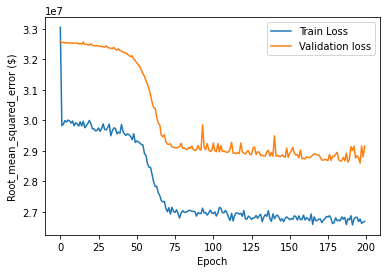

In [817]:
model = nn_model_1()
history = model.fit(X_train, y_train, epochs=200,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
history_model_1 = history
plot_history(history_model_1)

In [818]:
print_results_NN(history_model_1,X_test,y_test)

Last epoch: 199
Last RMSE score on development set: 29155406

RMSE on test set: 29456892
R^2 on test set: 0.1847


In [821]:
# Build model 
def nn_model_2(): 
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=154, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', 
                  metrics=[root_mean_squared_error])
    return model


....................................................................................................
....................................................................................................

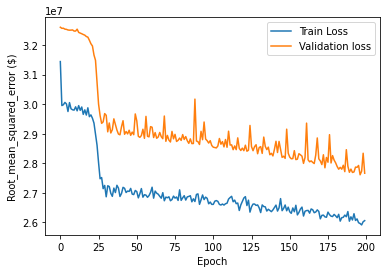

In [822]:
model = nn_model_2()
history = model.fit(X_train, y_train, epochs=200,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
history_model_2 = history
plot_history(history)

In [824]:

print_results_NN(history_model_2,X_test,y_test)

Last epoch: 199
Last RMSE score on development set: 27664998

RMSE on test set: 28111591
R^2 on test set: 0.2575


In [825]:
# Build model 
def nn_model_3(): 
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=154, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', 
                  metrics=[root_mean_squared_error])
    return model


....................................................................................................
....................................................................................................

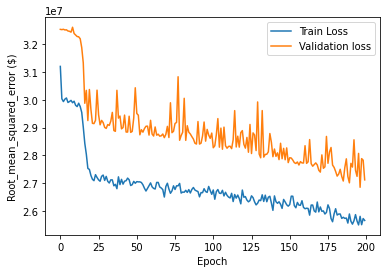

In [826]:
model = nn_model_3()
history = model.fit(X_train, y_train, epochs=200,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
history_model_3 = history
plot_history(history)

In [827]:
print_results_NN(history_model_3,X_test,y_test)

Last epoch: 199
Last RMSE score on development set: 27115202

RMSE on test set: 27752425
R^2 on test set: 0.2763


In [828]:
# Build model 
def nn_model_4(): 
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=154, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', 
                  metrics=[root_mean_squared_error])
    return model


....................................................................................................
....................................................................................................Wall time: 36.1 s


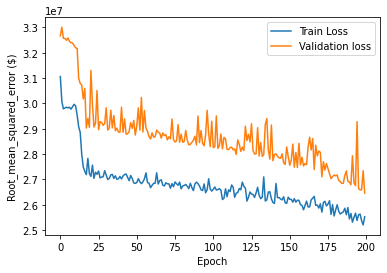

In [830]:
%%time
# one more running with timing
model = nn_model_4()
history = model.fit(X_train, y_train, epochs=200,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
history_model_4 = history
plot_history(history_model_4)

In [831]:
print_results_NN(history_model_4,X_test,y_test)

Last epoch: 199
Last RMSE score on development set: 26461500

RMSE on test set: 27301891
R^2 on test set: 0.2996


The best neural network model I found here is model 4. Here is the structure of model 4.

In [832]:
model=nn_model_4()
model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_187 (Dense)            (None, 128)               19840     
_________________________________________________________________
dense_188 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_189 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_190 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_191 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_192 (Dense)            (None, 1)                 257       
Total params: 250,497
Trainable params: 250,497
Non-trainable params: 0
_______________________________________________

In [833]:
print_results_NN(history_model_4,X_test,y_test)

Last epoch: 199
Last RMSE score on development set: 26461500

RMSE on test set: 27301891
R^2 on test set: 0.2996


# Feature Importances

In [22]:
# Make a function that draw a feature importance plot
def plot_feature_importances(model_name, importances, feature_names, num_features=None, 
                             fig_size=None, ax=None):
    features_importances = pd.DataFrame(sorted(zip(feature_names, importances), 
                                           key = lambda tup: tup[1], reverse=True),
                                   columns=['features','importances'])
    data = features_importances[:num_features]
    data.plot('features','importances', kind='barh', ax=ax,
              color='blue', figsize=fig_size, legend = None)
    plt.gca().invert_yaxis() # reverse the order of features
    plt.ylabel('feature importances')
    if num_features:
        plt.title(model_name + '\nTop '+str(num_features))
    else: 
        plt.title(model_name + '\nAll Features')

In [23]:
!pip install -U matplotlib
import matplotlib.pyplot as plt
import pandas as pd


  Using cached matplotlib-3.3.4-cp38-cp38-win_amd64.whl (8.5 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Phuc Nguyen\\anaconda3\\Lib\\site-packages\\matplotlib\\_image.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



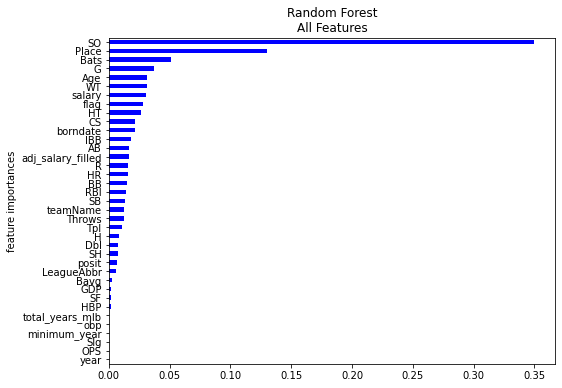

In [24]:

# Random Forest
importances = rf_trained.best_estimator_.feature_importances_
# all features
plot_feature_importances('Random Forest', importances, df_hitter.columns[1:], fig_size=(8,6))

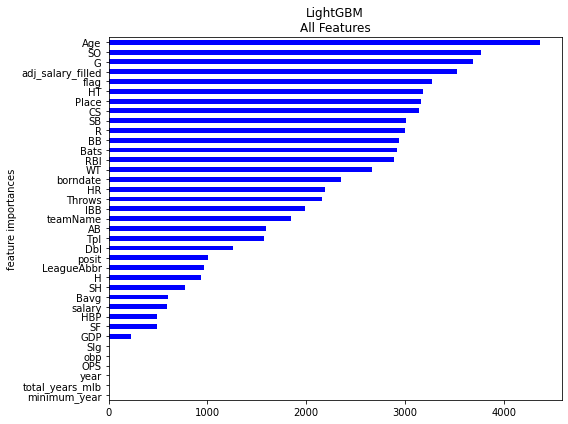

In [26]:

# LightGBM
importances = lgbm_trained.best_estimator_.named_steps['lgbm'].feature_importances_
# all features
plot_feature_importances('LightGBM', importances, df_hitter.columns[1:], fig_size=(8,6))
plt.tight_layout() # need for savefig
plt.savefig("Feature_importances_LightGBM_all.png",format="png", dpi=300)

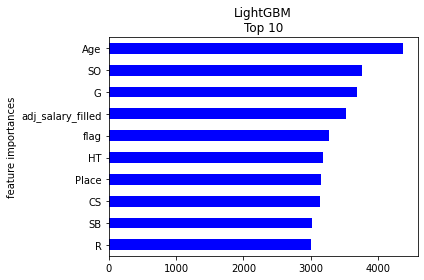

In [27]:
# LightGBM
importances = lgbm_trained.best_estimator_.named_steps['lgbm'].feature_importances_
plot_feature_importances('LightGBM', importances, df_hitter.columns[1:], num_features=10)
plt.tight_layout() # need for savefig
plt.savefig("Feature_importances_LightGBM_top10.png",format="png", dpi=300)

plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt 
model_summary = pd.DataFrame({'RMSE_val':[22615270,18853251,18248353,26461500], 
                            'RMSE_test':[23797151,19985546,19113579,27301891], 
                            'R_squared':[0.4679,0.6247,0.6567,0.2996],
                            'Time':['5.98 s','3min 6s','10min 31s', '36.1 s'],
                             'Scaling':[True, False,True, False]},
                           index=['LinearRegression', 'RandomForest','LightGBM','Neural Network'])
model_summary = model_summary.sort_values(by=['RMSE_test'])
model_summary

,RMSE_val,RMSE_test,R_squared,Time,Scaling
LightGBM,18248353,19113579,0.6567,10min 31s,True
RandomForest,18853251,19985546,0.6247,3min 6s,False
LinearRegression,22615270,23797151,0.4679,5.98 s,True
Neural Network,26461500,27301891,0.2996,36.1 s,False


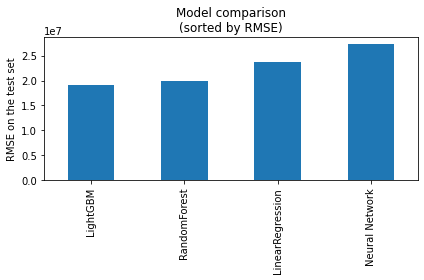

In [6]:

model_summary.RMSE_test.plot(kind='bar')
plt.ylabel('RMSE on the test set')
plt.title('Model comparison\n(sorted by RMSE)')
plt.tight_layout() # need for savefig
plt.savefig("Model_comparison.png",format="png", dpi=300)
plt.show()

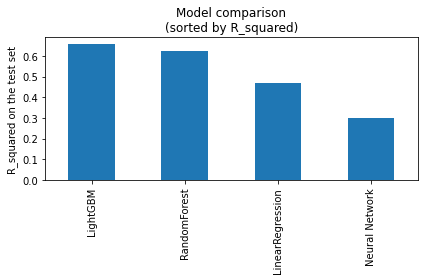

In [7]:
model_summary.R_squared.plot(kind='bar')
plt.ylabel('R_squared on the test set')
plt.title('Model comparison\n(sorted by R_squared)')
plt.tight_layout() # need for savefig
plt.savefig("Model_comparison.png",format="png", dpi=300)
plt.show()

LightGBM is best followed by RandomForest followed by LinearRegression